<h1 align="center">Volume 1: Facial Recognition.</h1>

    Caelan Osman
    Math 345 Sec 3
    November 16, 2020

In [2]:
import os
import numpy as np
from imageio import imread
from matplotlib import pyplot as plt
from numpy import linalg as la
from scipy import linalg as spla

### Helper Functions

In [3]:
def get_faces(path="./faces94"):
    """Traverse the specified directory to obtain one image per subdirectory. 
    Flatten and convert each image to grayscale.
    
    Parameters:
        path (str): The directory containing the dataset of images.  
    
    Returns:
        ((mn,k) ndarray) An array containing one column vector per
            subdirectory. k is the number of people, and each original
            image is mxn.
    """
    # Traverse the directory and get one image per subdirectory.
    faces = []
    for (dirpath, dirnames, filenames) in os.walk(path):
        for fname in filenames:
            if fname[-3:]=="jpg":       # Only get jpg images.
                # Load the image, convert it to grayscale,
                # and flatten it into a vector.
                faces.append(np.ravel(imread(dirpath+"/"+fname, as_gray=True)))
                break
    # Put all the face vectors column-wise into a matrix.
    return np.transpose(faces)


def sample_faces(k, path="./faces94"):
    """Generate k sample images from the given path.

    Parameters:
        n (int): The number of sample images to obtain. 
        path(str): The directory containing the dataset of images.  
    
    Yields:
        ((mn,) ndarray): An flattend mn-array representing a single
        image. k images are yielded in total.
    """
    files = []
    for (dirpath, dirnames, filenames) in os.walk(path):
        for fname in filenames:
            if fname[-3:]=="jpg":       # Only get jpg images.
                files.append(dirpath+"/"+fname)

    # Get a subset of the image names and yield the images one at a time.
    test_files = np.random.choice(files, k, replace=False)
    for fname in test_files:
        yield np.ravel(imread(fname, as_gray=True))

### Problem 1 

- Implement `show()`.
- Use `show()` to display a face from the `faces94` dataset.

In [4]:
def show(image, m=200, n=180):
    """Plot the flattened grayscale 'image' of width 'w' and height 'h'.
    
    Parameters:
        image ((mn,) ndarray): A flattened image.
        m (int): The original number of rows in the image.
        n (int): The original number of columns in the image.
    """
    #reshape the image
    reshaped = np.reshape(image,(m,n))
    #plot and show the image
    plt.imshow(reshaped, cmap='gray')
    

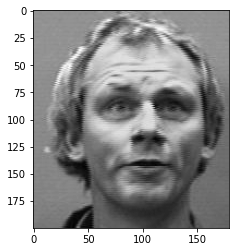

In [5]:
show(get_faces()[:, 0])
plt.show()

In [6]:
class FacialRec(object):
    """Class for storing a database of face images, with methods for
    matching other faces to the database.
    
    Attributes:
        F ((mn,k) ndarray): The flatten images of the dataset, where
            k is the number of people, and each original image is mxn.
        mu ((mn,) ndarray): The mean of all flatten images.
        Fbar ((mn,k) ndarray): The images shifted by the mean.
        U ((mn,k) ndarray): The U in the compact SVD of Fbar;
            the columns are the eigenfaces.
    """
    # Problems 2-3
    def __init__(self, path='./faces94'):
        """Initialize the F, mu, Fbar, and U attributes.
        This is the main part of the computation.
        """
        #get the faces
        self.F = get_faces(path)
        #set k
        self.k = self.F.shape[1]
        #construct the mean shifted face
        self.mu = self.F.sum(axis=1)/self.k
        #construct the mean shifted faces
        self.Fbar = self.F - np.vstack(self.mu)
        #construct U from the compact SVD of the mean shifted faces
        self.U, _, _ = la.svd(self.Fbar, full_matrices=False)

    # Problem 3
    def project(self, A, s):
        """Project a face vector onto the subspace spanned by the first s
        eigenfaces, and represent that projection in terms of those eigenfaces.
        
        Parameters:
            A((mn,) or (mn,l) ndarray): The array to be projected. 
            s(int): the number of eigenfaces.
        Returns: 
            ((s,) ndarray): An array of the projected image of s eigenfaces.
        """
        #construct low rank approximation of U
        Us = self.U[:, :s]
        #return the project of A onto the span of Fbar
        return (Us.T @ A)

    # Problem 5
    def find_nearest(self, g, s=38):
        """Find the index j such that the jth column of F is the face that is
        closest to the face image 'g'.
        
        Parameters:
            g ((mn,) ndarray): A flattened face image.
            s (int): the number of eigenfaces to use in the projection.

        Returns:
            (int): the index of the column of F that is the best match to
                   the input face image 'g'.
        """
        #get projection of g
        ghat = self.project((g - self.mu), s)
        #get projection of F
        Fhat = self.project(self.Fbar, s)
        #get the index of the minimum norm of the difference
        return np.argmin(spla.norm((Fhat-np.vstack(ghat)), axis=0))

    # Problem 6
    def match(self, image, s=38, m=200, n=180):
        """Display an image along with its closest match from the dataset. 
        
        Parameters:
            image ((mn,) ndarray): A flattened face image.
            s (int): The number of eigenfaces to use in the projection.
            m (int): The original number of rows in the image.
            n (int): The original number of columns in the image.
        """
        
        #get best approximation index
        index = self.find_nearest(image, s)
        
        #plot
        ax1 = plt.subplot(121)
        show(image, m, n)
        ax1.axis('off')
        ax1.set_title('Original Image')
        ax2 = plt.subplot(122)
        show(self.F[:, index], m, n)
        ax2.axis('off')
        ax2.set_title('Best Match')
        plt.show()

### Problem 2

- In `FacialRec.__init__()`, compute $F$, the mean face $\boldsymbol{\mu}$, and the mean-shifted faces $\bar{F}$.
Store each as an attribute.

- Initialize a `FacialRec` object and display its mean face, plus an original image and its shifted face.

(36000, 153)


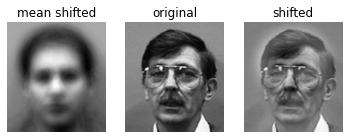

In [7]:
faces = FacialRec()
print(faces.U.shape)
ax1 = plt.subplot(131)
show(faces.mu)
ax1.axis('off')
ax1.set_title('mean shifted')
ax2 = plt.subplot(132)
show(faces.F[:, 1])
ax2.axis('off')
ax2.set_title('original')
ax3 = plt.subplot(133)
show(faces.Fbar[:, 1])
ax3.axis('off')
ax3.set_title('shifted')
plt.show()


### Problem 3

- In `FacialRec.__init__()`, compute the compact SVD of $\bar{F}$ and store the $U$ as an attribute.
- Use `show()` to display some of the eigenfaces (the columns of $U$).
- Implement `FacialRec.project()` (in a single line).


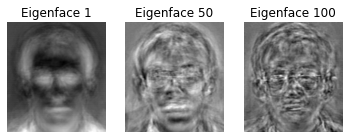

In [8]:
faces = FacialRec()
ax1 = plt.subplot(131)
show(faces.U[:, 0])
ax1.axis('off')
ax1.set_title('Eigenface 1')
ax2 = plt.subplot(132)
show(faces.U[:, 49])
ax2.axis('off')
ax2.set_title('Eigenface 50')
ax3 = plt.subplot(133)
show(faces.U[:, 99])
ax3.axis('off')
ax3.set_title('Eigenface 100')
plt.show()

### Problem 4

- Select one of the shifted images $\bar{\mathbf{f}}_i$.
- For at least 4 values of $s$, use `FacialRec.project()` to compute the corresponding $s$-projection $\widehat{\mathbf{f}}_i$, then compute the reconstruction $\widetilde{\mathbf{f}}_i$.
- Display each of the reconstructions and the original image.

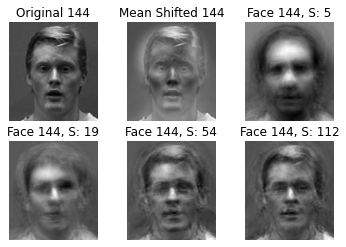

In [12]:
faces = FacialRec()
shifted = faces.Fbar[:, 143]
s = [5, 19, 54, 112]
#get the projections
projections = [faces.project(shifted, s[i]) for i in range(4)]
#get reconstruction
reconstruction = [((faces.U[:, :s[i]] @ projections[i]) + faces.mu) for i in range(4)]

#plot
ax = plt.subplot(231)
show(faces.F[:, 143])
ax.set_title('Original 144')
ax.axis('off')
ax0 = plt.subplot(232)
show(faces.Fbar[:, 143])
ax0.set_title('Mean Shifted 144')
ax0.axis('off')
ax1 = plt.subplot(233)
show(reconstruction[0])
ax1.set_title('Face 144, S: 5')
ax1.axis('off')
ax2 = plt.subplot(234)
show(reconstruction[1])
ax2.set_title('Face 144, S: 19')
ax2.axis('off')
ax3 = plt.subplot(235)
show(reconstruction[2])
ax3.set_title('Face 144, S: 54')
ax3.axis('off')
ax4 = plt.subplot(236)
show(reconstruction[3])
ax4.set_title('Face 144, S: 112')
ax4.axis('off')
plt.show()

### Problem 5 
Implement `FacialRec.find_nearest()`.

### Problem 6

- Implement `FacialRec.match()`.
- Generate some random faces with `sample_faces()`, and use `FacialRec.match()` to find the closest match (let $s=38$).
- For each test, display the sample image and its closest match.

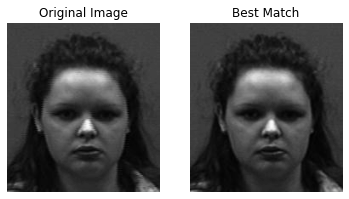

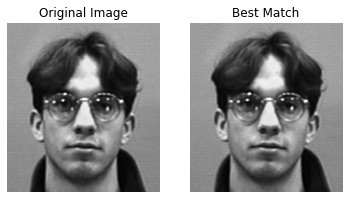

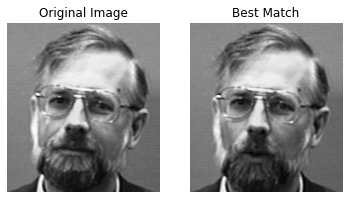

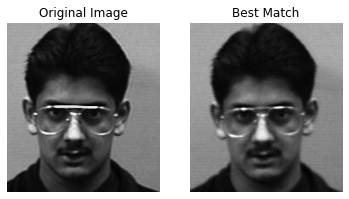

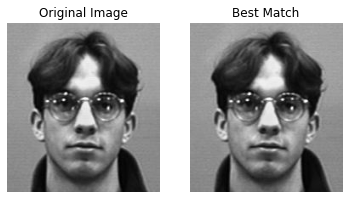

In [10]:
faces = FacialRec()

for test_image in sample_faces(5):
    faces.match(test_image)
    